In [ ]:
#%pip install uproot awkward tqdm mplhep plotly pandas fastjet

In [1]:
from utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import uproot
import awkward as ak

In [51]:
sc = uproot.open("data/SC.root")["Events"].arrays(
    ["L1PF_pt", "L1PF_eta", "L1PF_phi", "L1PF_pdgId"],
    library="ak"
)

fp = uproot.open("data/FP.root")["Events"].arrays(library="ak",
    filter_name=[
        "GenVisTaus_*",
        "L1nnPuppiTaus_*",
        "L1PFCands_*",
        "L1PFJets_*",
    ],
)

print("Loaded", len(sc["L1PF_pt"]), "events.")

Loaded 7128 events.


In [52]:
# GRID SEARCH

R_seed_grid = [0.35, 0.40]
R_cen_grid  = [0.35, 0.40]
R_clu_grid  = [0.35, 0.40]

results = []
best_L = 1e9

grid = [(a,b,c) for a in R_seed_grid for b in R_cen_grid for c in R_clu_grid]

print(f"\nStarting grid search over {len(grid)} combinations...\n")

for (R_seed, R_cen, R_clu) in tqdm(grid, desc="Grid search"):

    L, mu, sigma = evaluate_point(sc[:300], fp[:300], R_seed, R_cen, R_clu)

    if L < best_L:
        best_L = L
        print(f"\n NEW BEST L={L:.4f}  "
              f"mean={mu:.3f}, std={sigma:.3f}  "
              f"| R_seed={R_seed}, R_cen={R_cen}, R_clu={R_clu}\n")

    results.append({
        "R_seed": R_seed,
        "R_cen": R_cen,
        "R_clu": R_clu,
        "loss": L,
        "mean": mu,
        "std": sigma,
    })


results = sorted(results, key=lambda x: x["loss"])


Starting grid search over 8 combinations...



Grid search:   0%|          | 0/8 [00:00<?, ?it/s]

      > event 0/300
      > event 50/300
      > event 100/300
      > event 150/300
      > event 200/300
      > event 250/300


Grid search:  12%|█▎        | 1/8 [01:17<09:00, 77.24s/it]


 NEW BEST L=0.1974  mean=0.855, std=0.420  | R_seed=0.35, R_cen=0.35, R_clu=0.35

      > event 0/300
      > event 50/300
      > event 100/300
      > event 150/300
      > event 200/300
      > event 250/300


Grid search:  25%|██▌       | 2/8 [02:34<07:42, 77.08s/it]


 NEW BEST L=0.1922  mean=0.860, std=0.415  | R_seed=0.35, R_cen=0.35, R_clu=0.4

      > event 0/300
      > event 50/300
      > event 100/300
      > event 150/300
      > event 200/300
      > event 250/300


Grid search:  38%|███▊      | 3/8 [03:52<06:27, 77.58s/it]

      > event 0/300
      > event 50/300
      > event 100/300
      > event 150/300
      > event 200/300
      > event 250/300


Grid search:  50%|█████     | 4/8 [05:08<05:08, 77.02s/it]

      > event 0/300
      > event 50/300
      > event 100/300
      > event 150/300
      > event 200/300
      > event 250/300


Grid search:  62%|██████▎   | 5/8 [06:20<03:45, 75.17s/it]

      > event 0/300
      > event 50/300
      > event 100/300
      > event 150/300
      > event 200/300
      > event 250/300


Grid search:  75%|███████▌  | 6/8 [07:32<02:28, 74.13s/it]

      > event 0/300
      > event 50/300
      > event 100/300
      > event 150/300
      > event 200/300
      > event 250/300


Grid search:  88%|████████▊ | 7/8 [08:44<01:13, 73.42s/it]

      > event 0/300
      > event 50/300
      > event 100/300
      > event 150/300
      > event 200/300
      > event 250/300


Grid search: 100%|██████████| 8/8 [09:59<00:00, 74.89s/it]


In [53]:
print("\n====== BEST 5 COMBINATIONS ======")

for i, r in enumerate(results[:5], 1):
    print(f"[{i}]  R_seed={r['R_seed']:.3f}  "
          f"R_cen={r['R_cen']:.3f}  "
          f"R_clu={r['R_clu']:.3f}  |  "
          f"loss={r['loss']:.4f}  "
          f"mean={r['mean']:.4f}  "
          f"std={r['std']:.4f}")


====== BEST 5 COMBINATIONS ======
[1]  R_seed=0.350  R_cen=0.350  R_clu=0.400  |  loss=0.1922  mean=0.8597  std=0.4154
[2]  R_seed=0.350  R_cen=0.350  R_clu=0.350  |  loss=0.1974  mean=0.8545  std=0.4198
[3]  R_seed=0.400  R_cen=0.350  R_clu=0.400  |  loss=0.2182  mean=0.7974  std=0.4209
[4]  R_seed=0.400  R_cen=0.400  R_clu=0.350  |  loss=0.2182  mean=0.7974  std=0.4209
[5]  R_seed=0.400  R_cen=0.400  R_clu=0.400  |  loss=0.2182  mean=0.7974  std=0.4209


/tmp/ipykernel_652/1113112029.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


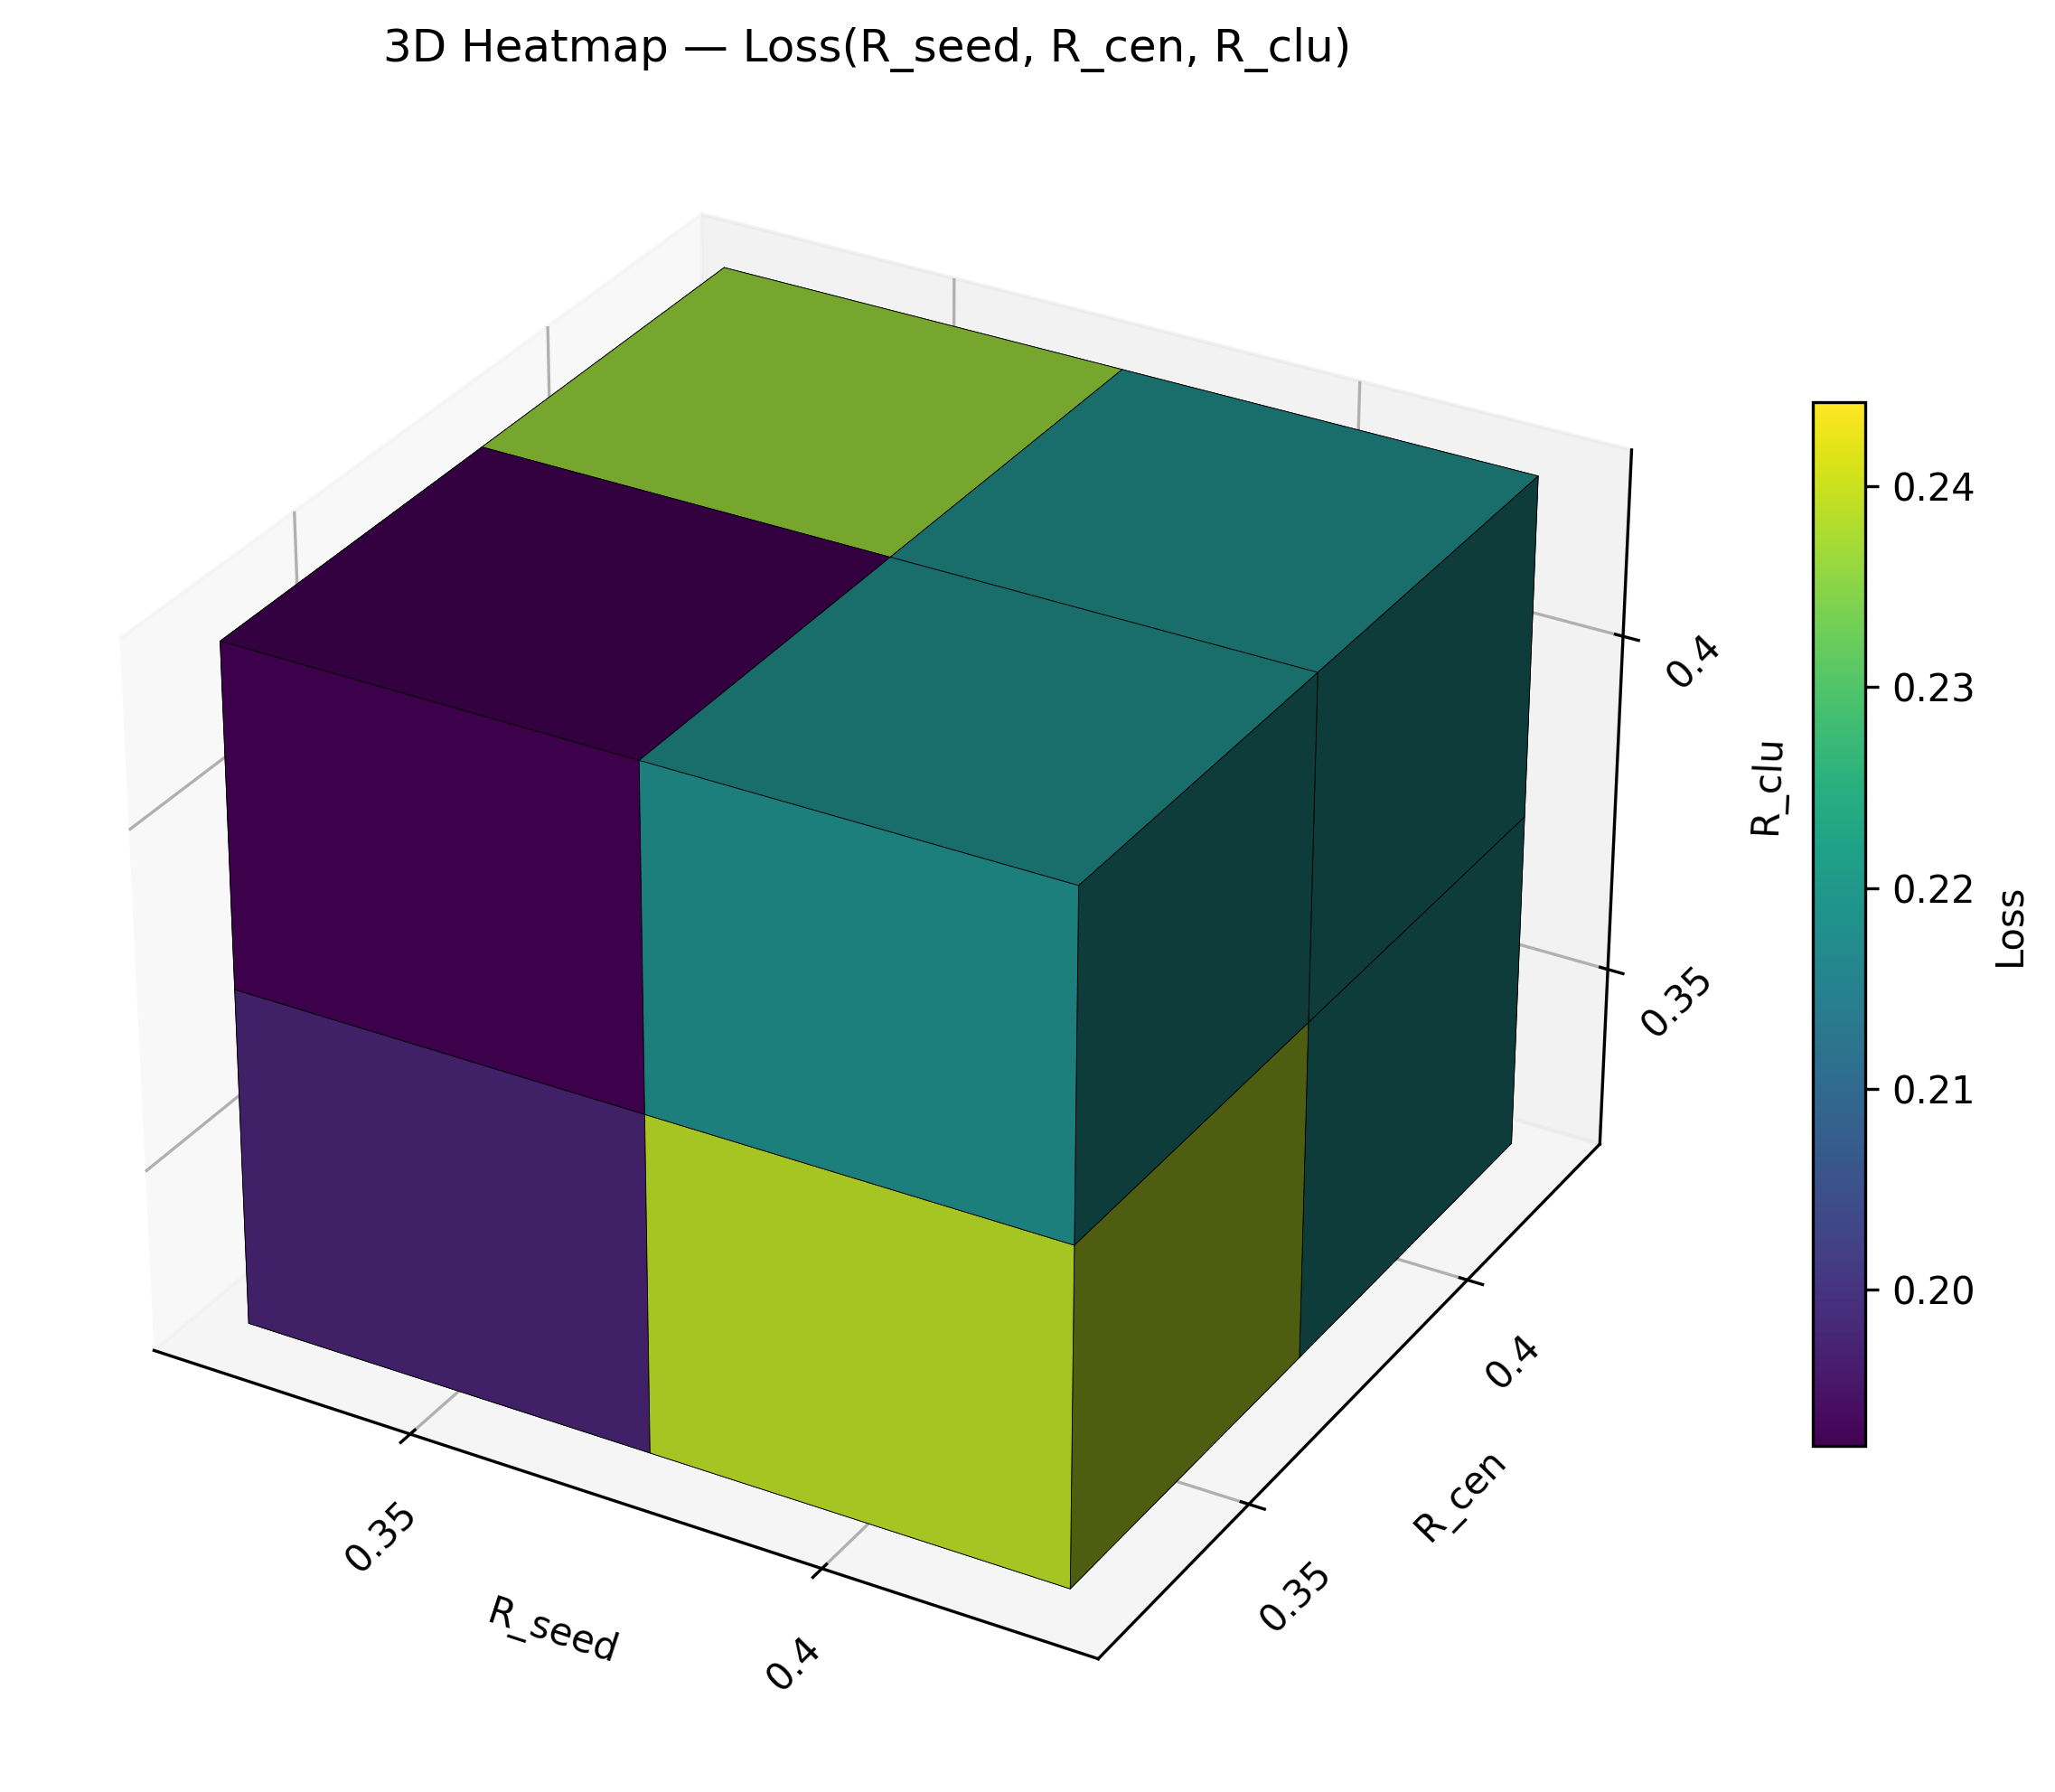

In [54]:
df = pd.DataFrame(results)

xs = sorted(df["R_seed"].unique())
ys = sorted(df["R_cen"].unique())
zs = sorted(df["R_clu"].unique())

vol = np.zeros((len(xs), len(ys), len(zs)))

for _, row in df.iterrows():
    i = xs.index(row["R_seed"])
    j = ys.index(row["R_cen"])
    k = zs.index(row["R_clu"])
    vol[i, j, k] = row["loss"]

vmin, vmax = vol.min(), vol.max()
norm = (vol - vmin) / (vmax - vmin + 1e-9)

filled = np.ones_like(vol, dtype=bool)

colors = cm.viridis(norm)

fig = plt.figure(figsize=(10,10), dpi = 300)
ax = fig.add_subplot(projection="3d")

ax.voxels(
    filled,
    facecolors=colors,
    edgecolor="k",
    linewidth=0.2,
)

ax.set_xticks(np.arange(len(xs)) + 0.5)
ax.set_yticks(np.arange(len(ys)) + 0.5)
ax.set_zticks(np.arange(len(zs)) + 0.5)

ax.set_xticklabels(xs, rotation=45)
ax.set_yticklabels(ys, rotation=45)
ax.set_zticklabels(zs, rotation=45)

ax.set_xlabel("R_seed")
ax.set_ylabel("R_cen")
ax.set_zlabel("R_clu")
ax.set_title("3D Heatmap — Loss(R_seed, R_cen, R_clu)")

mappable = cm.ScalarMappable(cmap="viridis")
mappable.set_array(vol)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=20, label="Loss")


plt.tight_layout()
plt.savefig('gplots/rid_search_SC.png', dpi = 300)
plt.show()

## Run clustering

In [57]:
N_EVENTS = 10000

BEST_R_SEED = 0.35
BEST_R_CEN  = 0.35
BEST_R_CLU  = 0.40

print(f"Running clustering on {len(sc[:N_EVENTS]["L1PF_pt"])} events...")

jets_pt   = []
jets_eta  = []
jets_phi  = []
jets_mass = []

assign_list = []
is_seed_list = []

for ievt in tqdm(range(len(sc[:N_EVENTS]["L1PF_pt"])), desc="Events"):

    pt  = ak.to_numpy(sc["L1PF_pt"][ievt])
    eta = ak.to_numpy(sc["L1PF_eta"][ievt])
    phi = ak.to_numpy(sc["L1PF_phi"][ievt])

    # clustering
    assign, seed_mask = seeded_cone_njets0(
        eta, phi, pt,
        R_seed=BEST_R_SEED,
        R_cen=BEST_R_CEN,
        R_clu=BEST_R_CLU
    )

    assign_list.append(assign.copy())
    is_seed_list.append(seed_mask.astype(np.int32))

    # build jets
    jpt, jeta, jphi, jmass = build_clusters(pt, eta, phi, assign)

    jets_pt.append(jpt)
    jets_eta.append(jeta)
    jets_phi.append(jphi)
    jets_mass.append(jmass)


Running clustering on 7128 events...


Events: 100%|██████████| 7128/7128 [31:59<00:00,  3.71it/s]


In [58]:
outfile = "data/SC_python.root"
print(f"\nWriting ROOT file: {outfile}")

with uproot.recreate(outfile) as fout:

    all_branches = {}

    for name in sc.fields:
        all_branches[name] = sc[:N_EVENTS][name]

    for name in fp.fields:
        if name in all_branches:
            all_branches[f"FP_{name}"] = fp[:N_EVENTS][name]   
        else:
            all_branches[name] = fp[:N_EVENTS][name]

    all_branches["ScoutPFTaus_pt"]   = ak.Array(jets_pt)
    all_branches["ScoutPFTaus_eta"]  = ak.Array(jets_eta)
    all_branches["ScoutPFTaus_phi"]  = ak.Array(jets_phi)
    all_branches["ScoutPFTaus_mass"] = ak.Array(jets_mass)

    all_branches["SC4AlpakaClusters_cluster"] = ak.Array(assign_list)
    all_branches["SC4AlpakaClusters_is_seed"] = ak.Array(is_seed_list)

    fout["Events"] = all_branches

print(f"\n File {outfile} saved successfully!")


Writing ROOT file: SC4njets0_python.root

 File SC4njets0_python.root saved successfully!
